In [1]:
import exasim_plot_helpers as eph
import obr
import pandas as pd
import sys
import os
import importlib.util
import matplotlib.pyplot as plt
import warnings

from obr.core.queries import query_to_dataframe, query_to_records, Query

# import concrete plot functions
spec = importlib.util.spec_from_file_location("plot", "../../../micro_benchmarks/common/plot_helpers.py")
pt = importlib.util.module_from_spec(spec)
sys.modules["plot"] = pt 
spec.loader.exec_module(pt)
benchmark_data_folder = "/home/greole/data/code/exasim_project/micro_benchmarks/LidDrivenCavity3D"

os.environ.setdefault("EXASIM_DATA_REPOSITORY", benchmark_data_folder)
os.environ.setdefault("EXASIM_SYSTEM_NAME", "nla")
os.environ.setdefault("GINKGO_EXECUTOR", "hip")

/home/greole/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'hip'

In [2]:
jobs = eph.signac_conversion.to_jobs(benchmark_data_folder)

In [3]:
base_query = [Query(key="executor", value="CPU"),Query(key="preconditioner", value="none") ]

In [4]:
q = list(eph.signac_conversion.build_annotated_query())
d = query_to_dataframe(jobs, q, strict=False, index=["nCells", "solver", "executor", "nSubDomains", "preconditioner"])
#d

In [5]:
d

SolveP  \
nCells   solver executor nSubDomains preconditioner                  
1000000  GKOCG  hip      8           BJ                 346.907947   
                                     BJ                 347.675947   
                                     BJ                 347.660211   
                                     none               348.491526   
                                     none               349.764368   
...                                                            ...   
64000000 PCG    CPU      8           none            666939.105263   
                         16          DIC             220473.263158   
                                     none            333339.526316   
                         32          DIC             108382.984211   
                                     none            169230.573684   

                                                     MomentumPredictor  \
nCells   solver executor nSubDomains preconditioner                      
1000000  GKOCG  hip      8           BJ                     179.805263   
                                     BJ                     179.911000   
                                     BJ                     180.159842   
                                     none                   178.668526   
                                     none                   181.431158   
...                                                                ...   
64000000 PCG    CPU      8           none                 15450.421053   
                         16          DIC                   7743.552632   
                                     none                  7728.444211   
                         32          DIC                   3889.553158   
                                     none                  3895.715789   

                                                     MatrixAssemblyU  \
nCells   solver executor nSubDomains preconditioner                    
1000000  GKOCG  hip      8           BJ                    23.710211   
                                     BJ                    24.039579   
                                     BJ                    23.311316   
                                     none                  25.086684   
                                     none                  23.658000   
...                                                              ...   
64000000 PCG    CPU      8           none                2086.072632   
                         16          DIC                 1036.026842   
                                     none                1044.927368   
                         32          DIC                  513.756789   
                                     none                 509.295526   

                                                     MatrixAssemblyPI:  \
nCells   solver executor nSubDomains preconditioner                      
1000000  GKOCG  hip      8           BJ                      25.350526   
                                     BJ                      25.372421   
                                     BJ                      24.947158   
                                     none                    25.710105   
                                     none                    25.399211   
...                                                                ...   
64000000 PCG    CPU      8           none                  2321.620000   
                         16          DIC                   1152.083684   
                                     none                  1154.645263   
                         32          DIC                    566.916105   
                                     none                   561.323684   

                                                     MatrixAssemblyPII:  \
nCells   solver executor nSubDomains preconditioner                       
1000000  GKOCG  hip      8           BJ                        8.593053   
                                     BJ                      

In [6]:
df = d.groupby(d.index).mean()
idx = df.index
df.index = pd.MultiIndex.from_tuples(idx, names=["nCells", "solver", "executor", "nSubDomains", "preconditioner"])
df

/tmp/ipykernel_3665101/1388510076.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = d.groupby(d.index).mean()


SolveP  \
nCells   solver executor nSubDomains preconditioner                  
1000000  GKOCG  hip      8           BJ                 347.414702   
                                     none               348.419123   
                         16          BJ                 369.730447   
                                     none               376.353079   
                         32          BJ                 532.167579   
                                     none               529.408079   
         PCG    CPU      8           DIC                503.241000   
                                     none               758.845579   
                         16          DIC                230.627053   
                                     none               393.812632   
                         32          DIC                153.536632   
                                     none               226.997158   
8000000  GKOCG  hip      8           BJ                2019.641053   
                                     none              2004.799474   
                         16          BJ                1806.152789   
                                     none              1802.637211   
                         32          BJ                2035.258132   
                                     none              2099.102895   
         PCG    CPU      8           DIC              23336.394737   
                                     none             42317.178947   
                         16          DIC              11844.040526   
                                     none             17069.835789   
                         32          DIC               4808.695263   
                                     none              6809.388947   
27000000 GKOCG  hip      8           BJ                6568.057544   
                                     none              6581.305263   
                         16          BJ                5995.518947   
                                     none              5977.552105   
                         32          BJ                6228.204474   
                                     none              6229.460789   
         PCG    CPU      8           DIC             131982.200000   
                                     none            217310.052632   
                         16          DIC              62794.910526   
                                     none            109467.068421   
                         32          DIC              32539.500000   
                                     none             54197.163158   
64000000 GKOCG  hip      8           BJ               18188.350526   
                                     none             18334.056140   
                         16          BJ               15774.744474   
                                     none             15597.832632   
                         32          BJ               16801.763947   
                                     none             16697.782105   
         PCG    CPU      8           DIC             435282.526316   
                                     none            666939.105263   
                         16          DIC             220473.263158   
                                     none            333339.526316   
                         32          DIC             108382.984211   
                                     none            169230.573684   

                                                     MomentumPredictor  \
nCells   solver executor nSubDomains preconditioner                      
1000000  GKOCG  hip      8           BJ                     179.958702   
                                     none                   180.070860   
                         16          BJ                      75.929053   
                                     none                    75.530868   
                         32          BJ                      38.054447   
                                     none

In [7]:
nla_full_node_base_query = [
    Query(key="solver", value="PCG"), 
    #Query(key="completed", value=True), // Does not work
    Query(key="preconditioner", value="none"),
    Query(key="nSubDomains", value=32)]    

../../../micro_benchmarks/common/plot_helpers.py:40: UserWarning: Dataframe has non-unique index, this could be a result of changed jobids, the results are averaged over same ids
  warnings.warn(f"Dataframe has non-unique index, this could be a result of changed jobids, the results are averaged over same ids")
../../../micro_benchmarks/common/plot_helpers.py:41: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.groupby(df.index).mean()


            SolveP  MomentumPredictor  MatrixAssemblyU  MatrixAssemblyPI:  \
nCells                                                                      
1000000   0.651506           0.216431         0.149974           0.279418   
8000000   3.396544           0.224451         0.229093           0.233451   
27000000  8.235017           0.247895         0.248407           0.243224   
64000000  9.230395           0.251954         0.244782           0.238678   

          MatrixAssemblyPII:  TimeStep  
nCells                                  
1000000             0.336457  0.515094  
8000000             0.243925  1.942652  
27000000            0.244432  4.609098  
64000000            0.246987  5.519338  
             SolveP  MomentumPredictor  MatrixAssemblyU  MatrixAssemblyPI:  \
nCells                                                                       
1000000    0.603149           0.515988         0.380850           0.616816   
8000000    3.777459           0.465375         0.464148  

  File "/home/greole/data/code/exasim_project/exasim_plot_helpers/src/plot_funcs.py", line 31, in dispatch_plot
    fig.savefig(
  File "/home/greole/.local/lib/python3.9/site-packages/matplotlib/figure.py", line 3285, in savefig
    self.canvas.print_figure(fname, **kwargs)
  File "/home/greole/.local/lib/python3.9/site-packages/matplotlib/backend_bases.py", line 2338, in print_figure
    result = print_method(
  File "/home/greole/.local/lib/python3.9/site-packages/matplotlib/backend_bases.py", line 2204, in <lambda>
    print_method = functools.wraps(meth)(lambda *args, **kwargs: meth(
  File "/home/greole/.local/lib/python3.9/site-packages/matplotlib/_api/deprecation.py", line 410, in wrapper
    return func(*inner_args, **inner_kwargs)
  File "/home/greole/.local/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py", line 517, in print_png
    self._print_pil(filename_or_obj, "png", pil_kwargs, metadata)
  File "/home/greole/.local/lib/python3.9/site-packages/matplotlib/

            SolveP  MomentumPredictor  MatrixAssemblyU  MatrixAssemblyPI:  \
nCells                                                                      
1000000   0.651506           0.216431         0.149974           0.279418   
8000000   3.396544           0.224451         0.229093           0.233451   
27000000  8.235017           0.247895         0.248407           0.243224   
64000000  9.230395           0.251954         0.244782           0.238678   

          MatrixAssemblyPII:  TimeStep  
nCells                                  
1000000             0.336457  0.515094  
8000000             0.243925  1.942652  
27000000            0.244432  4.609098  
64000000            0.246987  5.519338  
             SolveP  MomentumPredictor  MatrixAssemblyU  MatrixAssemblyPI:  \
nCells                                                                       
1000000    0.603149           0.515988         0.380850           0.616816   
8000000    3.777459           0.465375         0.464148  

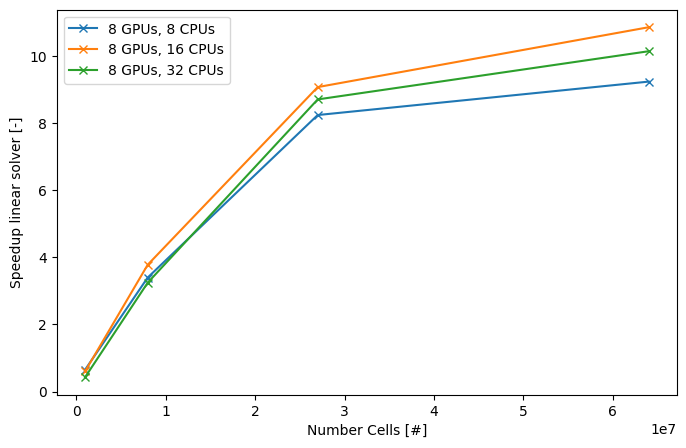

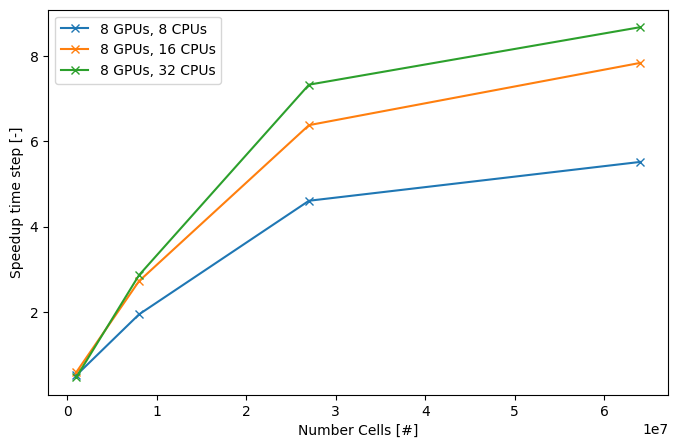

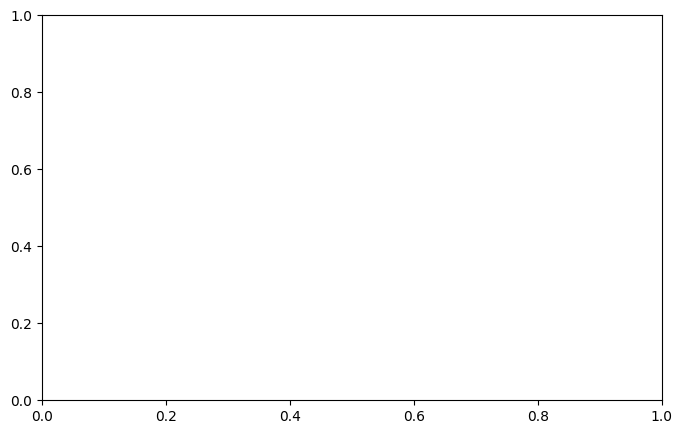

In [8]:
# repartitioned vs oversubscription
grouper = [
    #eph.helpers.PlotGroup(
    #    name = "Repartitioned ",
    #    queries =  [
    #        [Query(key="executor", value="hip"), 
    #         Query(key="ranksPerGPU"), 
    #         Query(key="completed", value=True),
    #         Query(key="preconditioner", value="none"),
    #        ], nla_full_node_base_query],
    #    plot_properties = {"linestyle": "-", "marker": "o"}),
    eph.helpers.PlotGroup(
        name = "8 GPUS + MPI ",
        legend = "8 GPUs, {value} CPUs",
        queries = [
            [Query(key="executor", value="hip"), 
             Query(key="ranksPerGPU", negate=True), 
             Query(key="completed", value=True),
             Query(key="preconditioner", value="none"),
            ], nla_full_node_base_query],
        plot_properties = {"linestyle": "-", "marker": "x"})
]
#grouped_jobs = eph.helpers.group_jobs(jobs, grouper)
figs = pt.normalized_plots(jobs, "LidDrivenCavity3D",  grouper, append_to_fn="repartitioned_vs_oversubscription")

# 

In [9]:
# repartitioned vs oversubscription
nla_full_node_base_precond_query = [
    Query(key="solver", value="PCG"), 
    Query(key="completed", value=True),
    Query(key="preconditioner", value="DIC"),
    Query(key="nSubDomains", value=32)]   

grouper = [
    eph.helpers.PlotGroup(
        name = "repartition",
        queries =  [
            [Query(key="executor", value="hip"), 
             Query(key="ranksPerGPU"), 
             Query(key="completed", value=True),
             Query(key="preconditioner", value="BJ"),
            ], nla_full_node_base_precond_query],
        plot_properties = {"linestyle": "-"})
]
#grouped_jobs = eph.helpers.group_jobs(jobs, grouper)
pt.normalized_plots(jobs, "LidDrivenCavity3D", grouper, append_to_fn="repartitioned_vs_oversubscription")

TypeError: __init__() missing 1 required positional argument: 'legend'

In [7]:
pt.simple_break_down(jobs, "LidDrivenCavity3D")

KeyError: "['TimeStep', 'iter_p', 'iter_Ux', 'final_p', 'final_Ux'] not found in axis"

In [ ]:
pt.simple_break_down_rel(jobs, "LidDrivenCavity3D")

In [ ]:
pt.gko_break_down(jobs, "p", "LidDrivenCavity3D")

In [ ]:
query = eph.signac_conversion.build_gko_query("p")
df = eph.signac_conversion.from_query_to_df(jobs, query, index=["nCells", "solver", "executor"]) #, index=["nCells", "solver", "executor", "nSubDomains"])

In [8]:
base_query = [eph.helpers.query(idx="executor", val="CPU", op=lambda a,b: a==b)]
fig, axes = pt.facets_relative_to_base_over_x(df, "MPI ranks: {}", base_query=base_query, x="nCells", y="SolveP", facet="nSubDomains")

AttributeError: module 'plot' has no attribute 'facets_relative_to_base_over_x'

In [2]:
base_query = [eph.helpers.query(idx="executor", val="CPU", op=lambda a,b: a==b)]
fig, axes = pt.facets_relative_to_base_over_x(jobs, "MPI ranks: {}", base_query=base_query, x="nCells", y="TimeStep", facet="nSubDomains")

NameError: name 'jobs' is not defined

<AxesSubplot: xlabel='nCells,solver,executor,nSubDomains'>

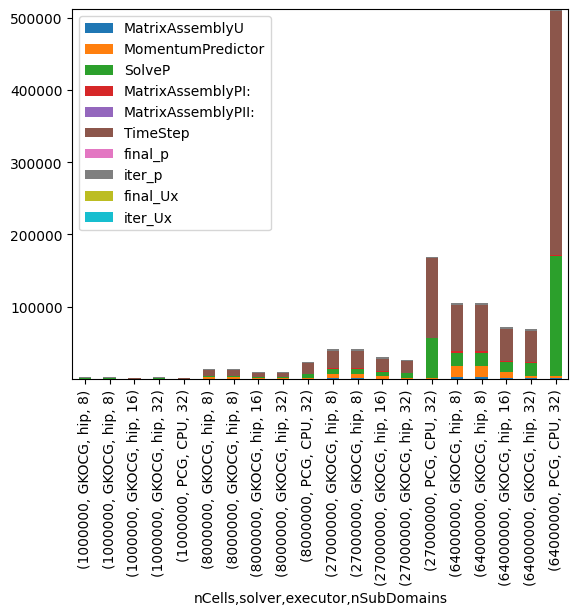

In [9]:
df.plot.bar(stacked=True)

In [29]:
speedup = eph.helpers.compute_speedup(
    eph.helpers.idx_query(
        df, [("nSubDomains", 16), ("executor", "hip")]), 
    [("executor", "CPU")], 
    ignore_indices=["solver", "nSubDomains"])

In [13]:
df.index.get_level_values(qs[0].idx)

Index(['GKOCG', 'GKOCG', 'GKOCG', 'GKOCG', 'PCG', 'GKOCG', 'GKOCG', 'GKOCG',
       'GKOCG', 'PCG', 'GKOCG', 'GKOCG', 'GKOCG', 'GKOCG', 'PCG', 'GKOCG',
       'GKOCG', 'GKOCG', 'GKOCG', 'PCG'],
      dtype='object', name='solver')

In [7]:
str(qs[0])

"query(idx='solver', val='GKOCG', op=<function not_equal at 0x7fd8c0b6b820>)"

In [11]:
equal

NameError: name 'equal' is not defined

In [6]:
os.environ

environ{'PATH': '/home/greole/.local/bin:/usr/local/bin:/opt/rocm-5.0.2/hip/bin:/opt/rocm-5.0.2/bin:/home/greole/.local/bin:/usr/local/bin:/usr/share/Modules/bin:/usr/lib64/ccache:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/home/greole/bin:/home/greole/arm/forge/21.0.3/bin/:/home/greole/.local/bin:/home/greole/bin:/home/greole/arm/forge/21.0.3/bin/:/home/greole/.local/bin',
        'PYTHONPATH': '/home/greole/.local/lib/python3.6/site-packages',
        'LANG': 'en_US.UTF-8',
        'LC_ALL': 'en_GB.UTF-8',
        'JUPYTERHUB_API_TOKEN': '33f9504c64fd41ec849d3debaeda5a68',
        'JPY_API_TOKEN': '33f9504c64fd41ec849d3debaeda5a68',
        'JUPYTERHUB_CLIENT_ID': 'jupyterhub-user-greole',
        'JUPYTERHUB_HOST': '',
        'JUPYTERHUB_OAUTH_CALLBACK_URL': '/user/greole/oauth_callback',
        'JUPYTERHUB_OAUTH_SCOPES': '["access:servers!server=greole/", "access:servers!user=greole"]',
        'JUPYTERHUB_OAUTH_ACCESS_SCOPES': '["access:servers!server=greole/", "access:se

In [6]:
for job in jobs:
    print(job.sp)

{'case': 'CaseOnDisk', 'has_child': False, 'operation': 'decomposePar', 'modifyBlock': '(100 100 100)->(300 300 300)', 'controlDict': {'deltaT': 0.000166, 'endTime': 0.00333}, 'set': 'solvers/p', 'preconditioner': 'none', 'solver': 'PCG', 'forceHostBuffer': 1, 'verbose': 1, 'executor': 'CPU', 'method': 'simple', 'numberSubDomains': 32, 'fvSolution': {'set': 'solvers/p', 'ranksPerGPU': 4.0}}
{'case': 'CaseOnDisk', 'has_child': True, 'operation': 'fvSolution', 'modifyBlock': '(100 100 100)->(100 100 100)', 'controlDict': {'deltaT': 0.0005, 'endTime': 0.01}, 'set': 'solvers/p', 'preconditioner': 'none', 'solver': 'GKOCG', 'forceHostBuffer': 1, 'verbose': 1, 'executor': 'hip'}
{'case': 'CaseOnDisk', 'has_child': False, 'operation': 'decomposePar', 'modifyBlock': '(100 100 100)->(400 400 400)', 'controlDict': {'deltaT': 0.000125, 'endTime': 0.0025}, 'set': 'solvers/p', 'preconditioner': 'none', 'solver': 'PCG', 'forceHostBuffer': 1, 'verbose': 1, 'executor': 'CPU', 'method': 'simple', 'numb

In [ ]:
    S_{\text{TS}} = \frac{\phi/n_{CPU} + \left(1-\phi\right)/{S_{GPU}}}
    {\phi/n_{GPU} + \left(1-\phi\right)/{S_{GPU}}}

In [8]:
def speed_up(phi, S, Sorig, nGPU, x, res):
    """ Parameters:
    phi = ration offloaded non offloaded
    S = attainable speedup linear solve
    nGPU=number of GPUs
    x = ration nCPUs used vs nGPUS
    res = resolution
    """
    a = (phi[res]*x/nGPU) + (1-phi[res])/S[res]
    b = (phi[res]/nGPU + (1-phi[res])/S[res])
    return Sorig[res] * a/b

In [9]:
#speed_up(0.5, 10, 8, 4)

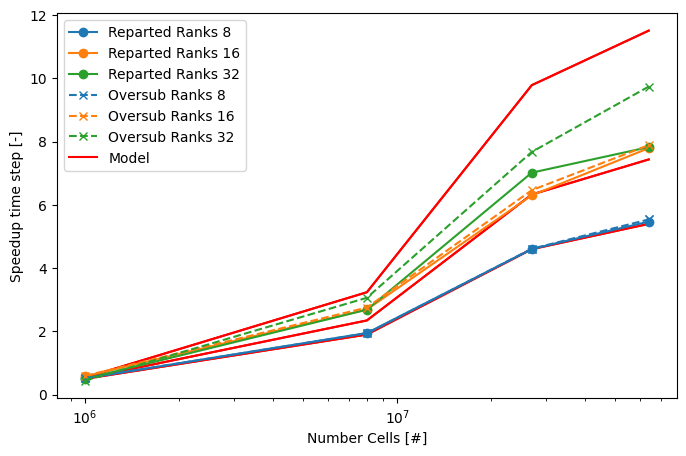

In [11]:
import numpy as np

# evenly sampled time at 200ms intervals
t =  [1e6, 8e6, 27e6, 64e6]

S = {1e6:0.44, 8e6:3, 27e6:8.2, 64e6: 9.0}
Sorig = {1e6:0.5, 8e6:1.9, 27e6:4.6, 64e6: 5.40}

phi = {
    1e6: (3+35+4+1)/136, 
    8e6:  0.45, # (455+65+16)/(6996*2), 
    27e6: 0.37, # (218+1613+240+68)/(57075), 
    #64e6: (509+3892+560+56+159)/(183489.*2),
    64e6: 0.35
}

# red dashes, blue squares and green triangles
speedup_1 = lambda x: speed_up(phi, S, Sorig, 8, 1, x)
speedup_2 = lambda x: speed_up(phi, S, Sorig, 8, 2, x)
speedup_4 = lambda x: speed_up(phi, S, Sorig, 8, 4, x)

figs["TimeStep"]["axis"].plot(t, [speedup_1(_) for _ in t], 'r-', t, [speedup_2(_) for _ in t], 'r-', t, [speedup_4(_) for _ in t], 'r-', zorder=0)
labels = figs["TimeStep"]["axis"].legend(
    [
        "Reparted Ranks 8", 
        "Reparted Ranks 16", 
        "Reparted Ranks 32", 
        "Oversub Ranks 8", 
        "Oversub Ranks 16", 
        "Oversub Ranks 32", 
        "Model"]
)
figs["TimeStep"]["axis"].set_xscale('log')
plt.show()
figs["TimeStep"]["fig"]

In [10]:
phi

{1000000.0: 0.3161764705882353,
 8000000.0: 0.07661520869068039,
 27000000.0: 0.03747700394218134,
 64000000.0: 0.02820877545792936}

In [53]:
1000000             0.966742  0.442596  
8000000             1.021672  3.062831  
27000000            0.985194  7.674033  
64000000            1.002097  9.741205

In [ ]:
1000000             0.331444  0.515400  
8000000             0.243589  1.947595  
27000000            0.244902  4.605400  
64000000            0.246990  5.471392